# Model Interpretability: From White-Box to Black-Box Explanations

## Why this notebook?

In many real-world projects, it's not enough to have a model with high accuracy.
We also need to **explain** how and why it makes predictions, especially in
sensitive domains like healthcare, finance, and credit scoring.

In this notebook, we will:

1. Load a real dataset (Breast Cancer dataset from scikit-learn).
2. Train simple, interpretable models (Logistic Regression, Decision Tree).
3. Train a more complex "black-box" model (Gradient Boosting).
4. Use **global** post-hoc explanation methods:
   - Permutation Feature Importance
   - Partial Dependence Plots (PDP)
5. Use **local** post-hoc explanation methods:
   - SHAP (SHapley Additive Explanations)
   - LIME (Local Interpretable Model-agnostic Explanations)

By the end, you should be able to:
- Explain the difference between **intrinsic** and **post-hoc** interpretability.
- Read and interpret coefficient plots, decision trees, SHAP and LIME outputs.


Imports & Basic Setup

In [2]:
# --- Core Libraries ---
import numpy as np
import pandas as pd

# --- Scikit-Learn for modeling and interpretation ---
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# --- Post-Hoc Interpretation Libraries ---
import shap
import lime
import lime.lime_tabular

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Settings for better visualization ---
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Libraries imported successfully.")


Libraries imported successfully.


Load and Prepare the Data

## 3. Load and Prepare the Data

We will use the **Breast Cancer** dataset from scikit-learn.

- Task: predict whether a tumor is **malignant (0)** or **benign (1)**.
- Each row = one patient.
- Each column = a measurement from the tumor (radius, texture, perimeter, etc.).


In [3]:
# Load the dataset
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df["target"] = cancer.target
df.head(20)




,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0


In [4]:
cancer = load_breast_cancer()
y = pd.Series(cancer.target)

y.value_counts()


1    357
0    212
Name: count, dtype: int64

In [5]:
# Load the dataset
cancer = load_breast_cancer()

# Convert features to a DataFrame for easier handling
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target  # 0: malignant, 1: benign

# Train/test split (with stratification to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Peek at the first few rows
X_train.head()


Training data shape: (455, 30)
Test data shape: (114, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
432,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
174,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
221,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
289,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994


Intrinsically Interpretable Models (White-Box)
Logistic Regression Coefficients

## 4A. Logistic Regression: Coefficient-Based Interpretation

Logistic Regression is a **linear model**. It learns a weight (coefficient) for
each feature.

- **Positive coefficient** → pushes prediction towards **benign (1)**.
- **Negative coefficient** → pushes prediction towards **malignant (0)**.
- The **magnitude** of the coefficient shows how strong that feature is.


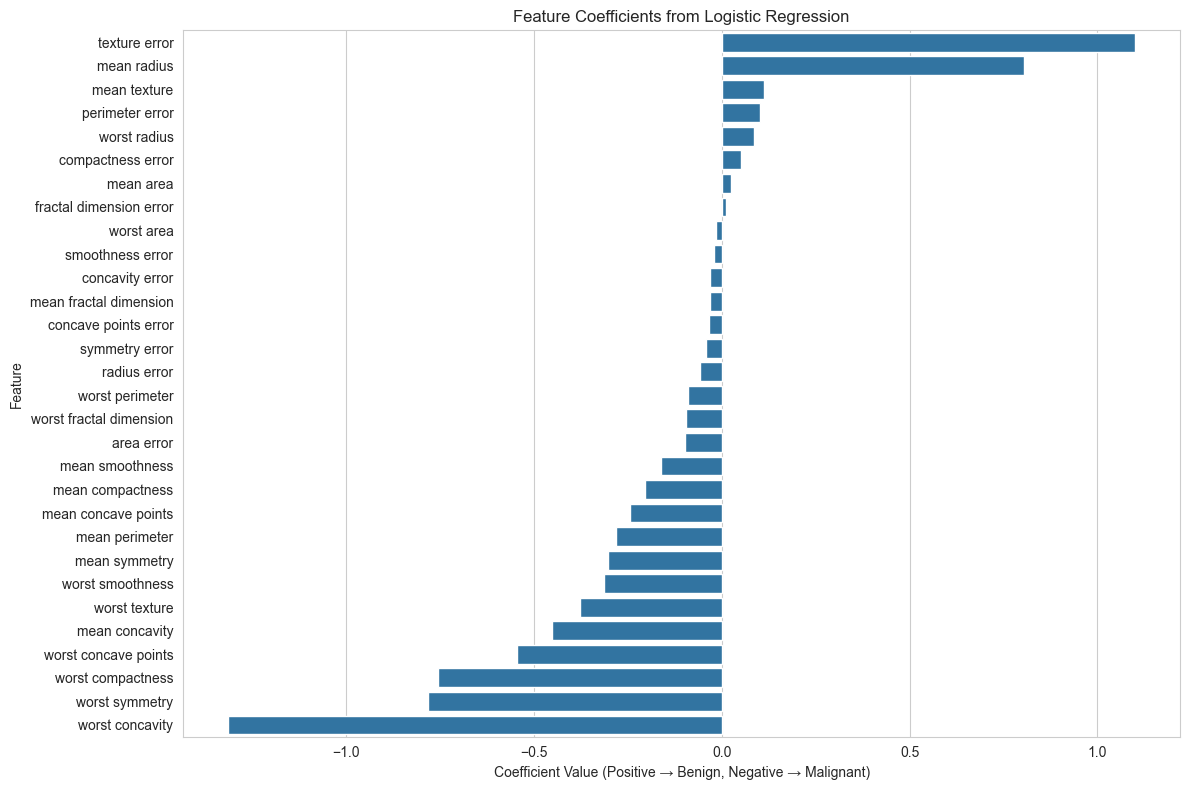

In [6]:
# Train a simple logistic regression model
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

# Put coefficients into a DataFrame
coefficients = pd.DataFrame(
    {"feature": X.columns, "coefficient": log_reg.coef_[0]}
)

# Sort features by coefficient value
coefficients = coefficients.sort_values("coefficient", ascending=False)

# Plot the coefficients
plt.figure(figsize=(12, 8))
sns.barplot(
    x="coefficient",
    y="feature",
    data=coefficients,
)
plt.title("Feature Coefficients from Logistic Regression")
plt.xlabel("Coefficient Value (Positive → Benign, Negative → Malignant)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


🔍 **Interpretation**

- Features with large **positive** coefficients strongly support the prediction
  "benign" (safe).
- Features with large **negative** coefficients strongly support "malignant".
- This gives us a **global view** of what the model has learned.


Decision Tree: Rule-Based Interpretation
## 4B. Decision Tree: Human-Readable Rules

A shallow Decision Tree (small depth) is easy to read:

- Each node has a **condition** (e.g., `worst radius <= 16.8`).
- You can follow a path from the root to a leaf to see **how a prediction is made**.


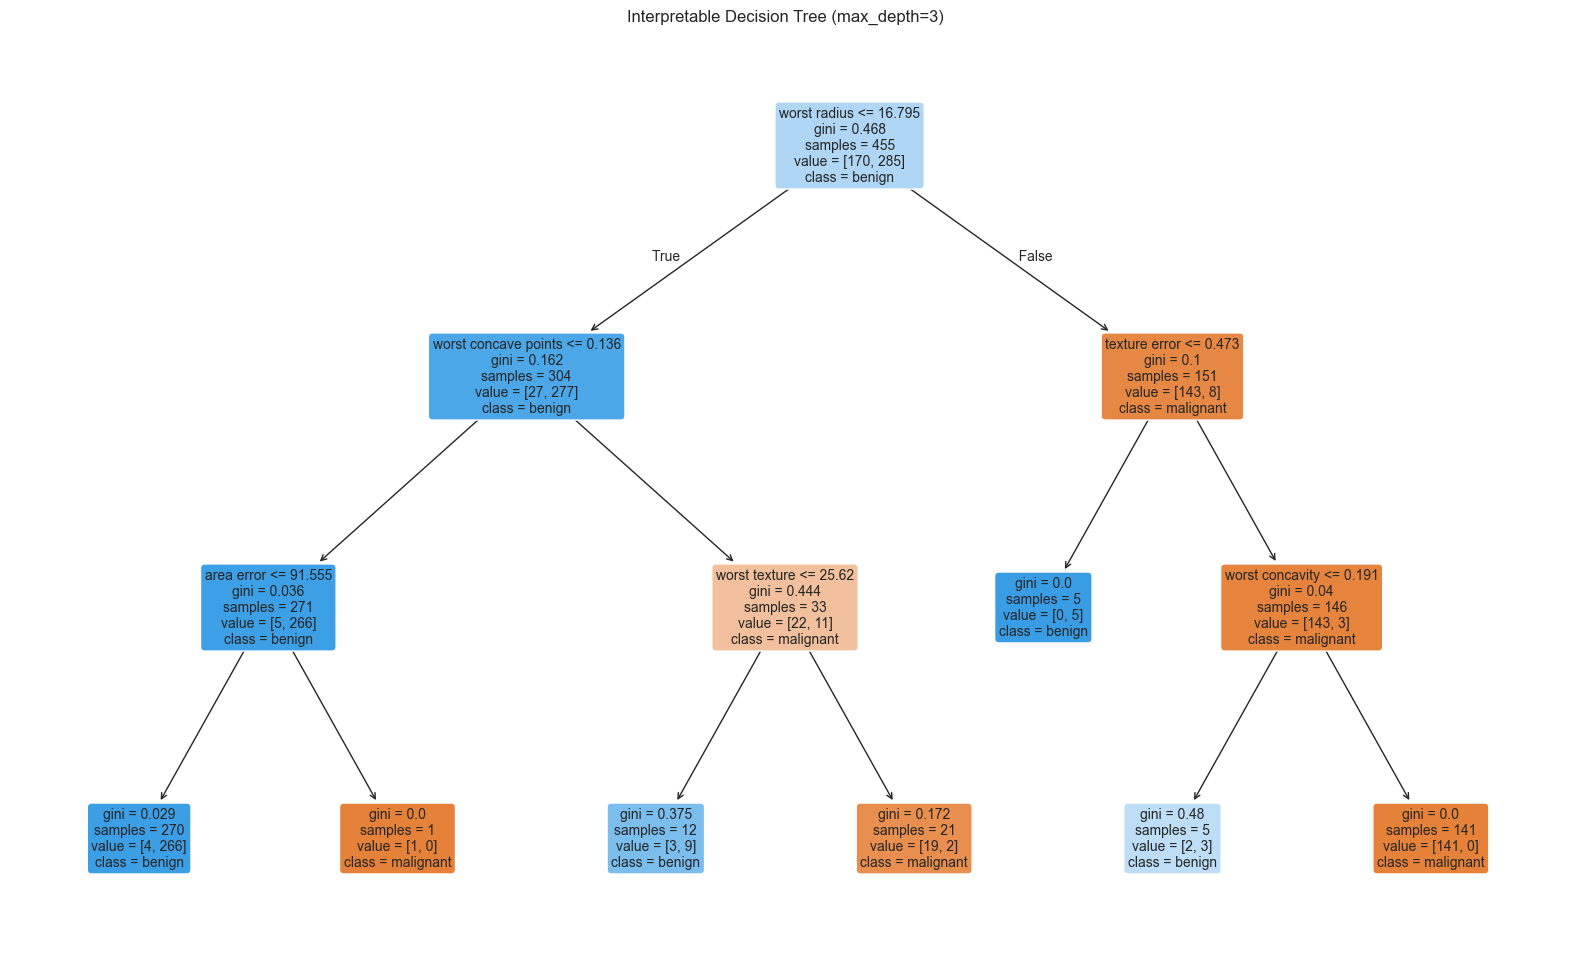

In [7]:
# Train a shallow decision tree
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 12))
plot_tree(
    tree_clf,
    feature_names=X.columns,
    class_names=cancer.target_names,  # ["malignant", "benign"]
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Interpretable Decision Tree (max_depth=3)")
plt.show()


🔍 **Interpretation**

You can pick any **leaf node** and read the path:

- Example:  
  If `worst radius <= 16.8` and `worst concave points <= 0.142`,  
  → the model might predict **benign** with high probability.

This is very easy to explain to a **doctor, regulator, or stakeholder**.


A More Powerful Black-Box Model (Gradient Boosting)
## 5. Gradient Boosting: A Strong but Opaque Model

Now we will train a **Gradient Boosting** classifier.

- It often has **better accuracy**.
- But it is harder to interpret directly (many trees, complex interactions).
- This is our **black-box** model that we will try to explain using post-hoc methods.


In [8]:
# Train a Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

# Compare accuracies
print(f"Logistic Regression Accuracy: {log_reg.score(X_test, y_test):.4f}")
print(f"Decision Tree Accuracy:       {tree_clf.score(X_test, y_test):.4f}")
print(f"Gradient Boosting Accuracy:   {gb_clf.score(X_test, y_test):.4f}")


Logistic Regression Accuracy: 0.9649
Decision Tree Accuracy:       0.9386
Gradient Boosting Accuracy:   0.9561


Global Post-Hoc Explanations
##  Permutation Feature Importance

Idea:

1. Measure the model’s accuracy on the test set.
2. **Randomly shuffle** one feature column (break its relationship to the target).
3. Measure how much the accuracy drops.
4. The **bigger the drop**, the more important the feature.

This works for **any model**, including black boxes.


<Figure size 1200x800 with 0 Axes>

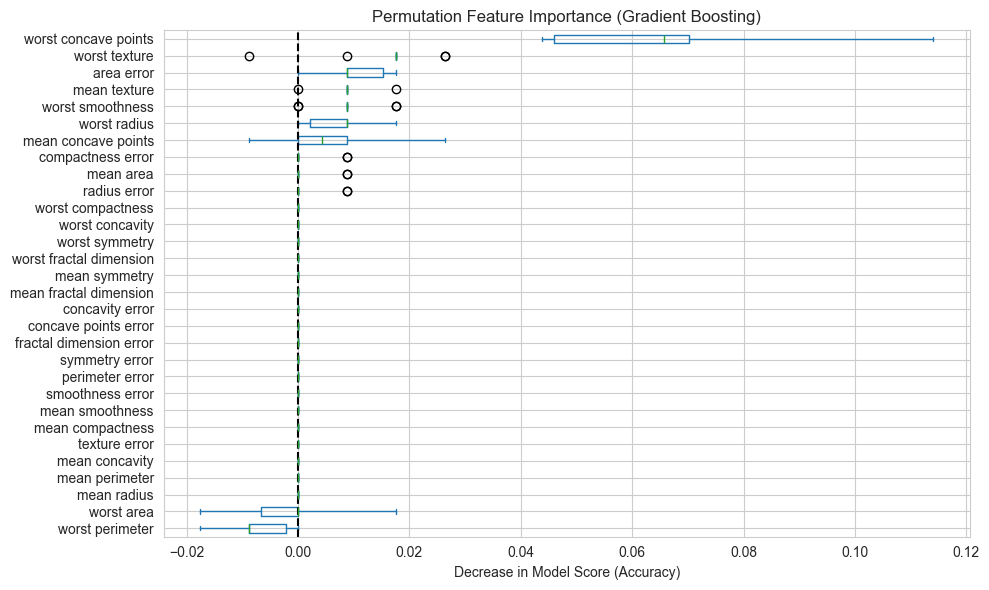

In [9]:
# Calculate permutation importance
perm_importance = permutation_importance(
    gb_clf, X_test, y_test, n_repeats=10, random_state=42
)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()
importance_df = pd.DataFrame(
    perm_importance.importances[sorted_idx].T,
    columns=X.columns[sorted_idx],
)

# Plot the importance as boxplots
plt.figure(figsize=(12, 8))
importance_df.plot(kind="box", vert=False, whis=10)
plt.title("Permutation Feature Importance (Gradient Boosting)")
plt.xlabel("Decrease in Model Score (Accuracy)")
plt.axvline(x=0, color="k", linestyle="--")
plt.tight_layout()
plt.show()


🔍 **Interpretation**

- Features further to the right cause larger accuracy drops when shuffled.
- Those are the **most important features** for the model.
- In this dataset, features like **`worst concave points`** and **`worst radius`**
  are usually among the top contributors.


Partial Dependence Plots (PDP)
## 6B. Partial Dependence Plots (PDP)

PDPs answer:

> "On average, how does the model’s prediction change when we vary **one feature**,  
> while keeping all others as they are in the dataset?"

This helps us understand **direction and shape** of a feature’s effect.


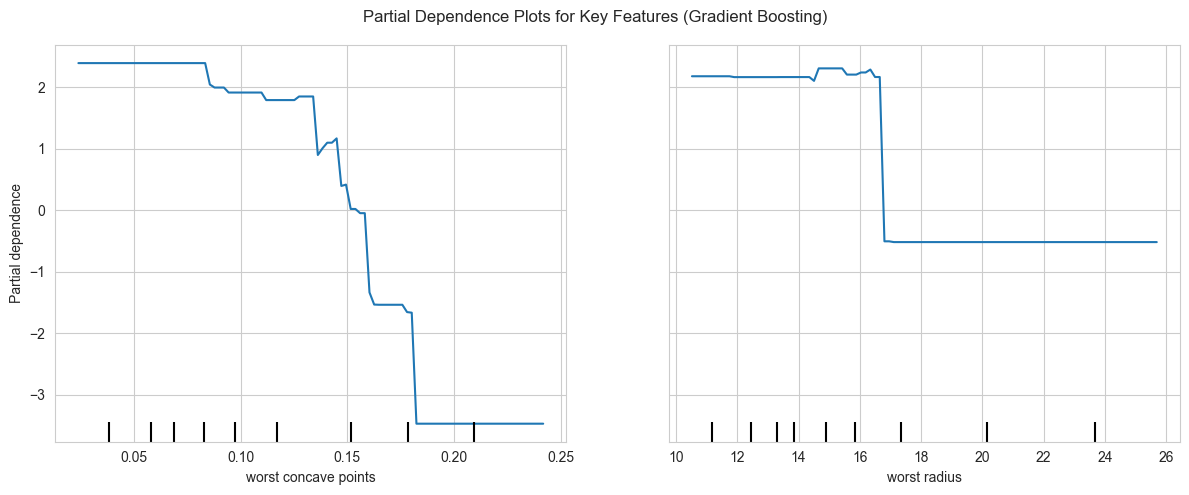

In [10]:
# Choose a couple of key features (based on importance)
features_to_plot = ["worst concave points", "worst radius"]

fig, ax = plt.subplots(figsize=(12, 5))
plt.suptitle("Partial Dependence Plots for Key Features (Gradient Boosting)")

PartialDependenceDisplay.from_estimator(
    gb_clf,
    X_train,
    features_to_plot,
    ax=ax,
)
plt.tight_layout()
plt.show()


🔍 **Interpretation**

- If the PDP curve goes **down** as the feature increases,  
  → higher values of that feature make the model predict **more malignant**.
- If it goes **up**, it supports **benign** predictions.

This gives a global, average view of how each feature influences predictions.


Local Explanations with SHAP
## 7. SHAP (SHapley Additive Explanations)

SHAP is based on ideas from **game theory**.

- Each feature is like a "player" in a game.
- SHAP value = how much that feature **contributes** to pushing the prediction
  away from the average (base) prediction.
- Works well with tree-based models (like Gradient Boosting).

We will:
1. Compute SHAP values for all test instances.
2. Look at a **global summary**.
3. Explain a **single patient** in detail.


In [11]:
# Initialize the SHAP explainer for a tree-based model
explainer = shap.TreeExplainer(gb_clf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

print("SHAP values computed.")


SHAP values computed.


SHAP Global Summary Plots

SHAP Summary Plot (Bar):


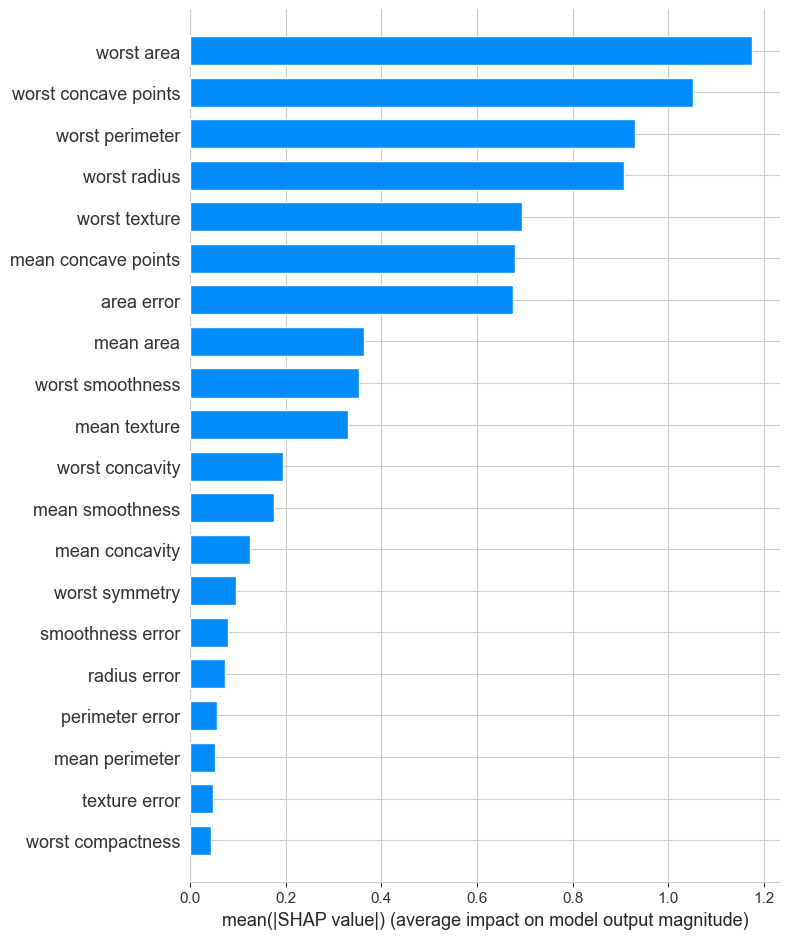

In [12]:
# Global bar summary (average absolute SHAP values)
print("SHAP Summary Plot (Bar):")
shap.summary_plot(shap_values, X_test, plot_type="bar")


SHAP Summary Plot (Dot):


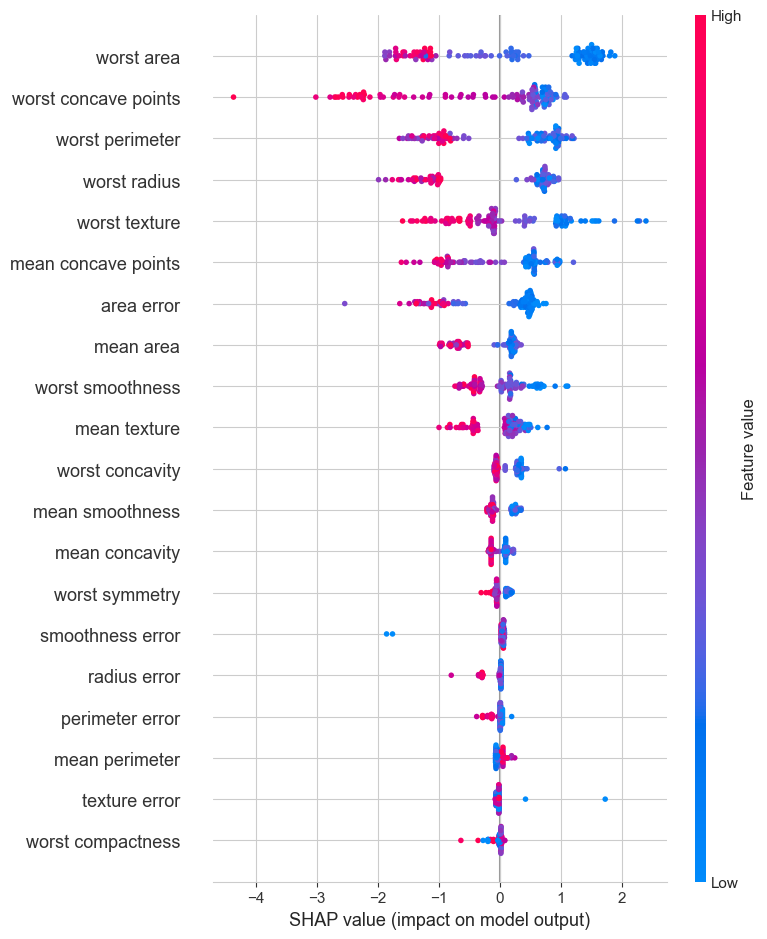

In [13]:
# Dot summary (shows impact and direction)
print("SHAP Summary Plot (Dot):")
shap.summary_plot(shap_values, X_test)


🔍 **Interpretation**

- **Bar plot**: ranks features by importance (similar story to permutation importance).
- **Dot plot**:
  - Each dot = one patient.
  - Color = feature value (red = high, blue = low).
  - Horizontal position = SHAP value (effect on the model output).


Local Explanations with LIME
##  LIME (Local Interpretable Model-Agnostic Explanations)

LIME builds a **simple, local, linear model** around one instance:

1. It creates many small perturbations of that instance.
2. Asks the black-box model for predictions.
3. Fits a simple model (e.g., linear) to approximate the black box **only in that local region**.

This gives a human-readable explanation like:

> "Because `worst concave points` is high and `worst radius` is high,
> the model predicts malignant."


c:\Users\hp\Documents\insurance-risk-analytics\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\hp\Documents\insurance-risk-analytics\.venv\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\hp\Documents\insurance-risk-analytics\.venv\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

LIME Explanation for instance 0:


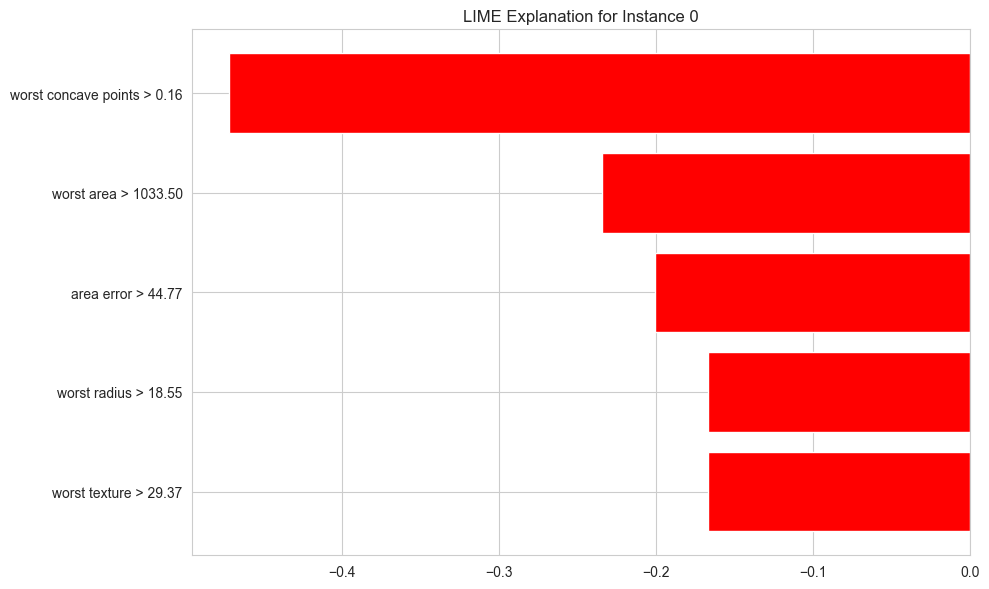

In [14]:
# Initialize the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=cancer.target_names.tolist(),
    mode="classification",
)

# Explain the same instance we used for SHAP
instance_index = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[instance_index],
    predict_fn=gb_clf.predict_proba,
    num_features=5,  # show top 5 features
)

print(f"LIME Explanation for instance {instance_index}:")
fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_index}")
plt.tight_layout()
plt.show()


🔍 **Interpretation**

- LIME shows a **small list of feature conditions** (e.g., `worst concave points > 0.15`)
  with positive or negative contributions.
- Green bars push towards the predicted class, red bars against it (depending on the plot).
- It acts like a small, local, approximate **ruleset** for the black-box model.
